# Assignment 2

### Author : Adarsh T. Shah, IISc, MTech(AI)

In [1]:
import numpy as np
from skimage import io,color,img_as_float32,img_as_ubyte
from matplotlib import pyplot as plt
from assignment1 import histogram
from math import e
import cv2

# 1. Contrast Enhancement

### 1.1 Full Scale Contrast Enhancement

In [2]:
def FSCS(image):
    image = img_as_float32(image)
    mn = np.min(image)
    mx = np.max(image)
    image = np.divide(np.subtract(image,mn),mx-mn)
    image = img_as_ubyte(image)
    return image

### 1.2 Non Linear Contrast Stretching

In [3]:
def NLCS(image):
    image = img_as_float32(image)
    image = np.log2(np.add(1,image))
    image = img_as_ubyte(image)
    image = FSCS(image)
    return image

### 1.3 Histogram Equalization

In [4]:
def HE(image):
    x,P = histogram(image,bins=256)
    sum = np.sum(P)
    for i in range(256):
        P[i]=P[i]/sum
    for i in range(1,256):
        P[i]+=P[i-1]
    func = lambda x : P[x]*255
    func = np.vectorize(func)
    image = np.round(func(image)).astype(int)
    image = FSCS(image)
    return image

### 1.4 CLAHE

In [47]:
def CLAHE(image,clip_limit=400):
    l,b = np.shape(image)
    l,b = l//8,b//8
    resimage = np.ones(shape=np.shape(image))
    for i in range(0,8):
        for j in range(0,8):
            img = image[i*l:(i+1)*l,j*b:(j+1)*b]
            _,P = histogram(img,bins=256)
            P = P.astype(int)
            clipped = 0
            for h in range(256):
                if P[h] > clip_limit:
                    clipped = clipped + P[h] - clip_limit
                    P[h] = clip_limit
            P = np.round(np.add(P,clipped/255))
            sum = np.sum(P)
            for k in range(256):
                P[k]=P[k]/sum
            for k in range(1,256):
                P[k]+=P[k-1]
            P = np.round(np.multiply(P,255))
            func = lambda x : P[x]
            func = np.vectorize(func)
            resimage[i*l:i*l+l,j*b:(j+1)*b] = func(img).astype(int)
    return resimage.astype(int)

### 1.5 CLAHE with 1.25%boundaries

In [71]:
def CLAHE1(image,clip_limit=400):
    l,b = np.shape(image)
    l,b = l//8,b//8
    resimage = np.ones(shape=np.shape(image))
    for i in range(0,8):
        for j in range(0,8):
            br,ur,bc,uc = i*l,i*l+l,j*b,j*b+b
            if i>0:
                br-=0.25*l
            if i<7:
                ur+=0.25*l
            if j>0:
                bc-=0.25*b
            if j<7:
                uc+=0.25*b
            br,ur,bc,uc = int(br),int(ur),int(bc),int(uc)
            img = image[br:ur,bc:uc]
            _,P = histogram(img,bins=256)
            P = P.astype(int)
            clipped = 0
            for h in range(256):
                if P[h] > clip_limit:
                    clipped = clipped + P[h] - clip_limit
                    P[h] = clip_limit
            P = np.round(np.add(P,clipped/255))
            sum = np.sum(P)
            for k in range(256):
                P[k]=P[k]/sum
            for k in range(1,256):
                P[k]+=P[k-1]
            P = np.round(np.multiply(P,255))
            func = lambda x : P[x]
            func = np.vectorize(func)
            resimage[i*l:i*l+l,j*b:(j+1)*b] = func(image[i*l:i*l+l,j*b:(j+1)*b]).astype(int)
    return resimage.astype(int)

In [55]:
def contrastEnhance(image,method='FSCS',clip_limit=400):
    if method == 'FSCS':
        return FSCS(image)
    elif method == 'NLCS':
        return NLCS(image)
    elif method == 'HE':
        return HE(image)
    elif method == 'CLAHE':
        return CLAHE(image,clip_limit=clip_limit)
    elif method == 'CLAHE1':
        return CLAHE1(image,clip_limit=clip_limit)

In [80]:
def testContrastEnhancement(method):
    files = ['inputs/IIScMainBuilding_LowContrast.png','inputs/LowLight_2.png','inputs/LowLight_3.png','inputs/Hazy.png','inputs/StoneFace.png']
    for file in files:
        image = io.imread(file)
        plt.subplot(221)
        plt.imshow(image,cmap=plt.cm.gray)
        x,y=histogram(image,bins=256)
        plt.subplot(222)
        plt.bar(x,y)
        resimg = contrastEnhance(image,method,clip_limit=1000)
        plt.subplot(223)
        plt.imshow(resimg,cmap=plt.cm.gray)
        x,y=histogram(resimg,bins=256)
        plt.subplot(224)
        plt.bar(x,y)
        plt.savefig('./outputs/1_'+method+'_'+file.split('/')[1])
        plt.show()
    

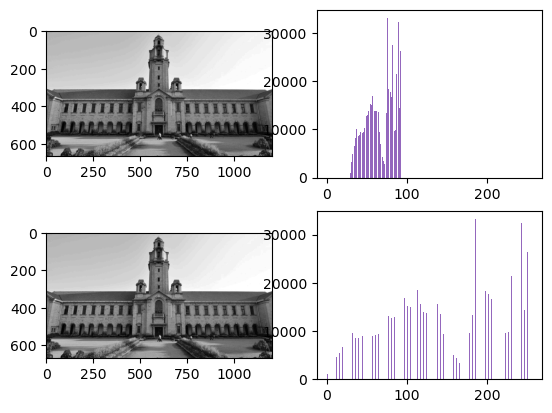

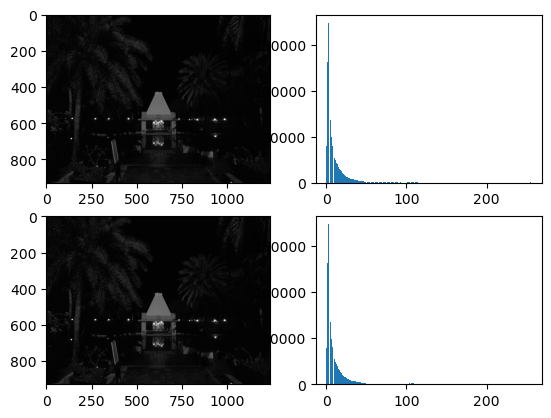

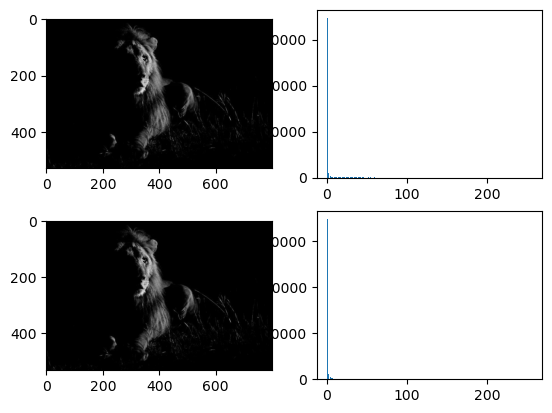

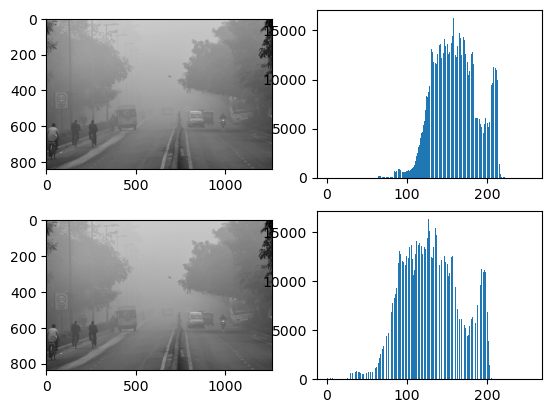

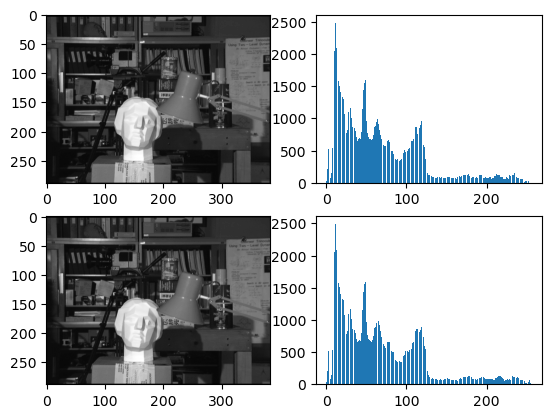

In [81]:
testContrastEnhancement(method='FSCS')

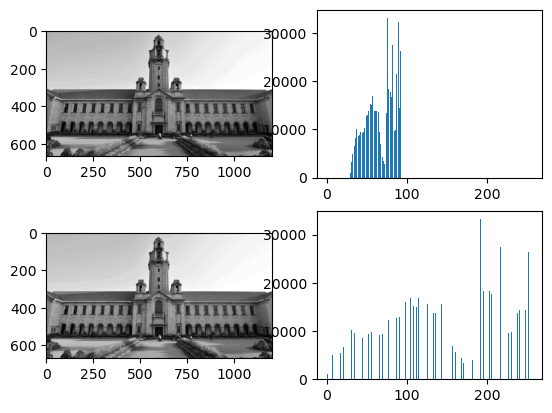

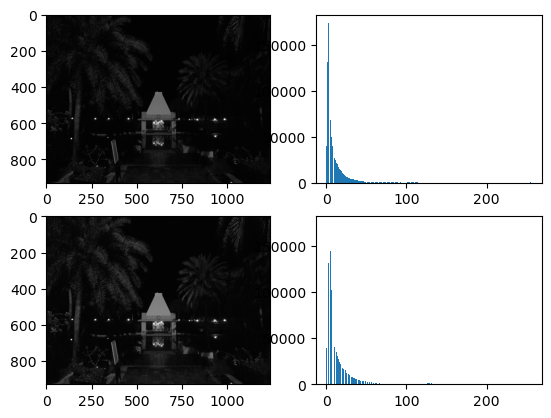

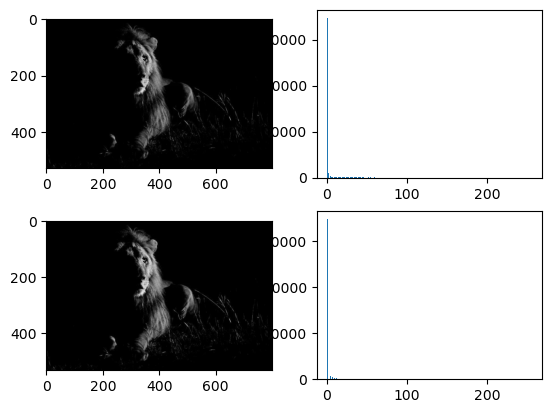

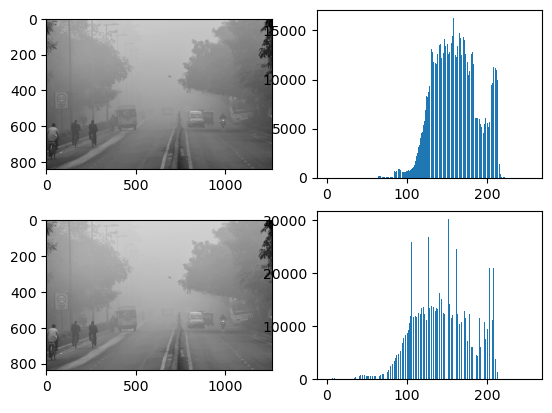

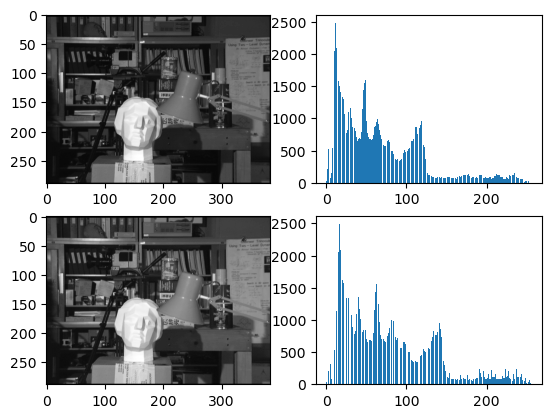

In [45]:
testContrastEnhancement(method='NLCS')

In [ ]:
testContrastEnhancement(method='HE')

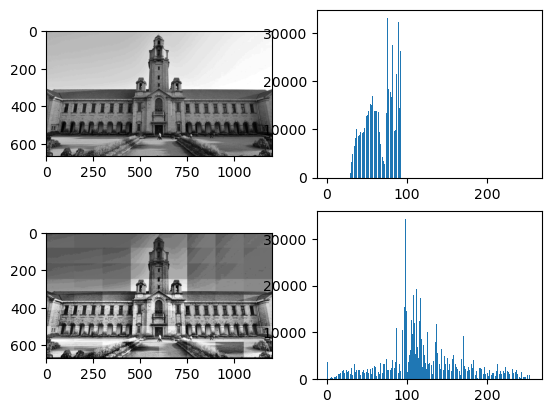

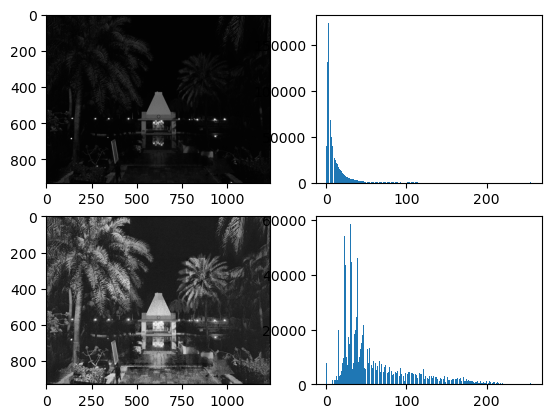

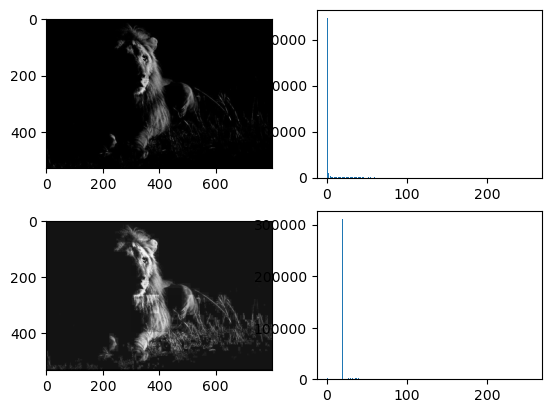

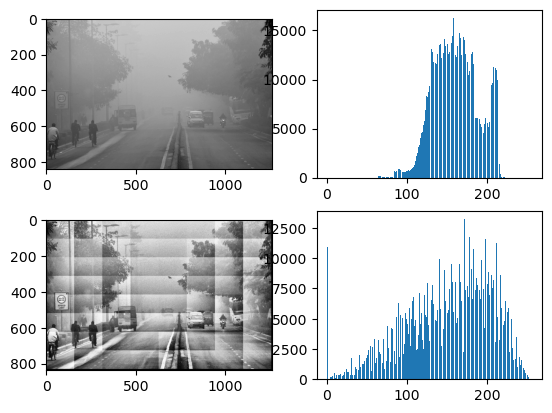

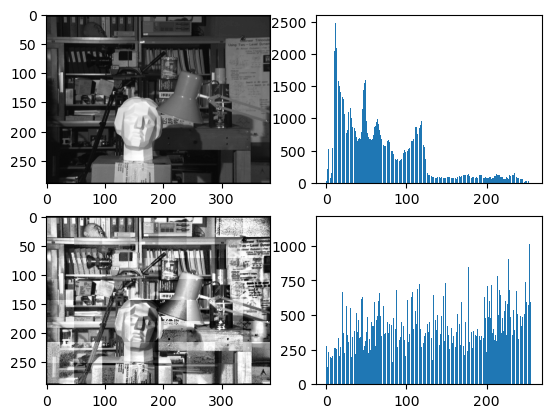

In [49]:
testContrastEnhancement(method='CLAHE')

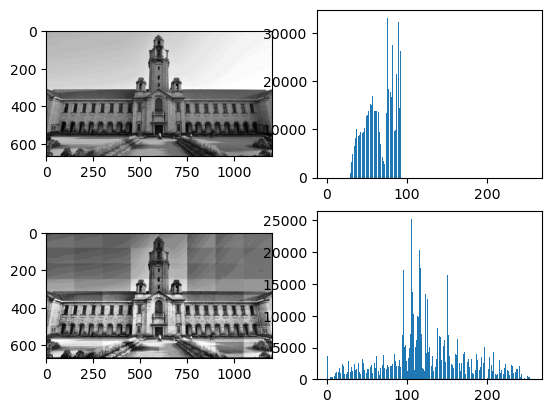

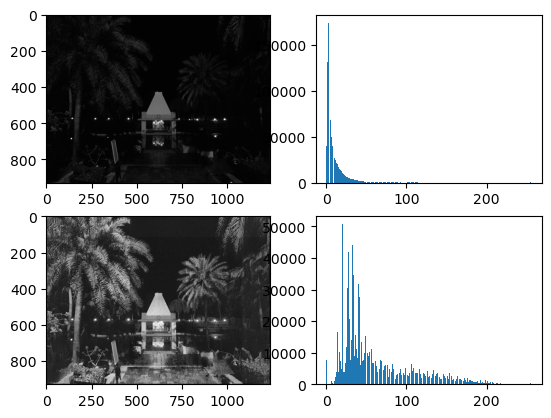

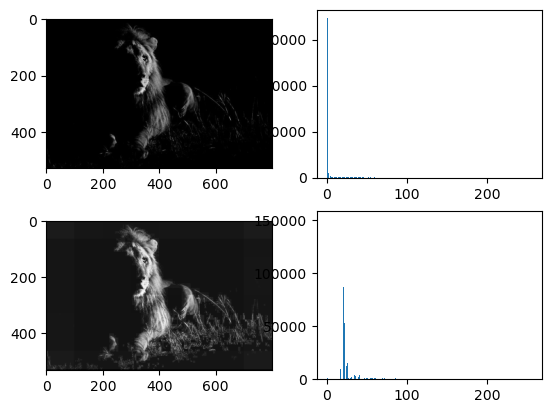

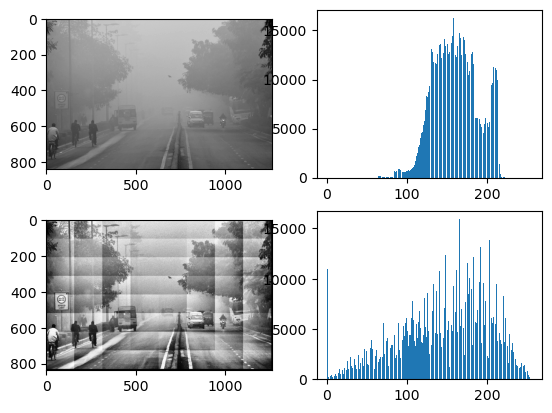

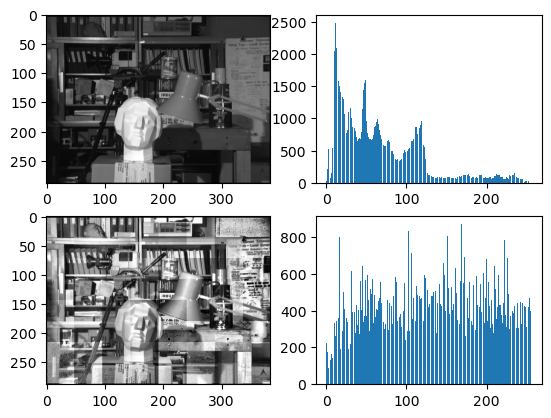

In [72]:
testContrastEnhancement(method='CLAHE1')